# 多层神经网络

本节在前面学习线性回归和逻辑回归模型的基础上，本节学习如何利用PyTorch实现多层神经网络。

## 1. 多层神经网络
线性回归的公式是 $y = w x + b$， Logistic 回归的公式是 $y = Sigmoid(w x + b)$，其实它们都可以看成单层神经网络，其中 Sigmoid 被称为激活函数。

### 1.1 神经网络的结构

神经网络就是很多个神经元堆在一起形成一层神经网络，那么多个层堆叠在一起就是深层神经网络

![nn demo](imgs/nn-forward.gif)

可以看到，神经网络的结构其实非常简单，主要有输入层，隐藏层，输出层构成，输入层需要根据特征数目来决定，输出层根据解决的问题来决定，那么隐藏层的网路层数以及每层的神经元数就是可以调节的参数，而不同的层数和每层的参数对模型的影响非常大，具体的动态示例可以参考 [demo - classify2d](http://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html) 。神经网络向前传播也非常简单，就是一层一层不断做运算即可。

### 1.2 多层神经网络示例程序

首先生成一些训练、测试数据。

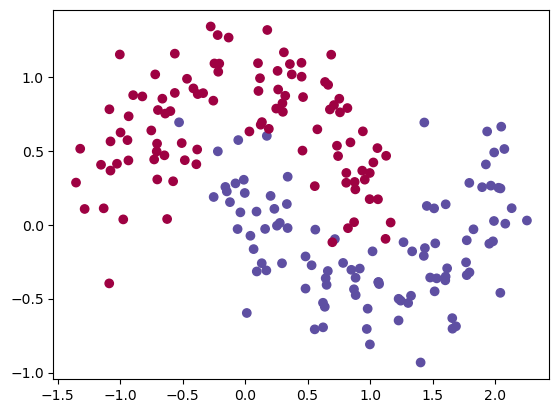

In [1]:
import torch
import numpy as np
from torch import nn
from sklearn import datasets

import matplotlib.pyplot as plt
%matplotlib inline

# generate sample data
np.random.seed(0)
data_x, data_y = datasets.make_moons(200, noise=0.20)

# plot data
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, cmap=plt.cm.Spectral)
plt.show()

In [2]:
# 变量
x = torch.from_numpy(data_x).float()
y = torch.from_numpy(data_y).float().unsqueeze(1)

# 定义两层神经网络的参数
w1 = nn.Parameter(torch.randn(2, 4) * 0.1) # 隐藏层神经元个数 4
b1 = nn.Parameter(torch.zeros(4))

w2 = nn.Parameter(torch.randn(4, 1) * 0.1)
b2 = nn.Parameter(torch.zeros(1))

# 定义模型
def SimpNetwork(x):
    x1 = torch.mm(x, w1) + b1
    x1 = torch.sigmoid(x1)          # 使用 PyTorch 自带的 sigmoid 激活函数
    x2 = torch.mm(x1, w2) + b2
    return x2                       # BCEWithLogitsLoss 已经带了sigmoid，所以此处不需要

optimizer = torch.optim.Adam([w1, b1, w2, b2], 0.1)

criterion = nn.BCEWithLogitsLoss()

In [3]:
for i in [x, y]:
    print(i.shape, type(i), type(i.numpy()), i.numpy().shape)

torch.Size([200, 2]) <class 'torch.Tensor'> <class 'numpy.ndarray'> (200, 2)
torch.Size([200, 1]) <class 'torch.Tensor'> <class 'numpy.ndarray'> (200, 1)


In [4]:
# 训练 1000 次
for e in range(1000):
    out = SimpNetwork(x)
    loss = criterion(out, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 100 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.item()))

epoch: 100, loss: 0.2919199764728546
epoch: 200, loss: 0.10144655406475067
epoch: 300, loss: 0.0761643573641777
epoch: 400, loss: 0.07124092429876328
epoch: 500, loss: 0.0690048485994339
epoch: 600, loss: 0.06704666465520859
epoch: 700, loss: 0.06487299501895905
epoch: 800, loss: 0.06260973960161209
epoch: 900, loss: 0.06042010709643364
epoch: 1000, loss: 0.05826660990715027


In [5]:
def plot_decision_boundary(model, x, y):
    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid .c_按行连接两个矩阵，左右相加。
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1), s=40, cmap=plt.cm.Spectral)

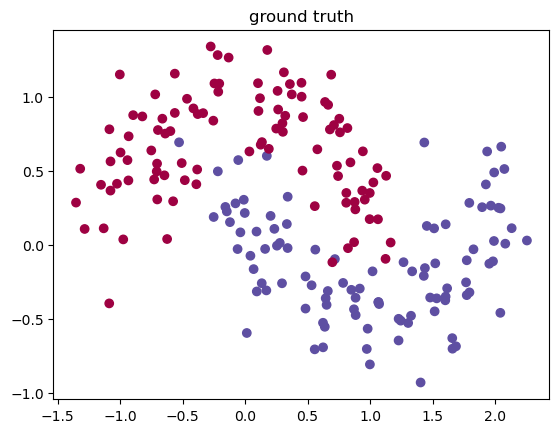

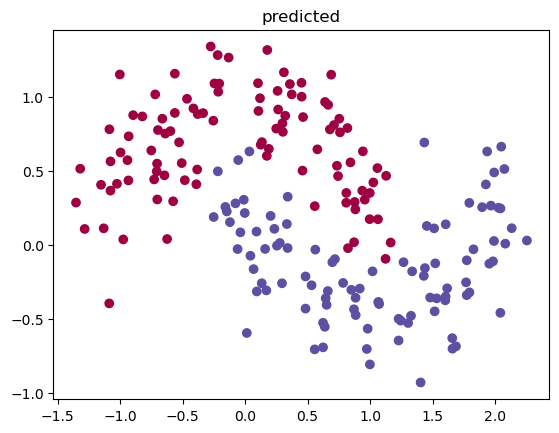

In [6]:
y_res  = torch.sigmoid(SimpNetwork(x))
#y_pred = np.argmax(y_res, axis=1)
y_pred = (y_res > 0.5)*1

# plot data
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Spectral)
plt.title("ground truth")
plt.show()

plt.scatter(x[:, 0], x[:, 1], c=y_pred, cmap=plt.cm.Spectral)
plt.title("predicted")
plt.show()

## 2. Sequential 和 Module


对于前面的线性回归模型、 Logistic回归模型和神经网络，在构建的时候定义了需要的参数。这对于比较小的模型是可行的，但是对于大的模型，比如100 层的神经网络，这个时候再去手动定义参数就显得非常麻烦，所以 PyTorch 提供了两个模块来帮助我们构建模型，一个是Sequential，一个是 Module。

Sequential 允许我们构建序列化的模块，而 Module 是一种更加灵活的模型定义方式，下面分别用 `Sequential` 和 `Module` 来定义上面的神经网络。

### 2.1 Sequential

In [7]:
from torch import nn

# Sequential
seq_net = nn.Sequential(
    nn.Linear(2, 4), # PyTorch 中的线性层，wx + b
    nn.Tanh(),       # 非线性激活函数
    nn.Linear(4, 1)  # 第二个线性层
)

In [8]:
# 序列模块可以通过索引访问每一层
seq_net[0] # 第一层

Linear(in_features=2, out_features=4, bias=True)

In [9]:
# 打印出第一层的权重

w0 = seq_net[0].weight
print(w0)

Parameter containing:
tensor([[ 0.0280,  0.5409],
        [-0.1989, -0.5726],
        [ 0.0471,  0.6792],
        [ 0.2310,  0.0103]], requires_grad=True)


In [10]:
# generate sample data

# np.random.seed(0)
# data_x, data_y = datasets.make_moons(200, noise=0.20)

# 变量

# x = torch.from_numpy(data_x).float()
# y = torch.from_numpy(data_y).float().unsqueeze(1)

# 通过 parameters 可以取得模型的参数
param = seq_net.parameters()

# 定义优化器
optim = torch.optim.SGD(param, lr=0.1)

# 我们训练 10000 次
for e in range(10000):
    out = seq_net(x)
    loss = criterion(out, y)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.item()))

epoch: 1000, loss: 0.3043045103549957
epoch: 2000, loss: 0.30169185996055603
epoch: 3000, loss: 0.2981189489364624
epoch: 4000, loss: 0.24776172637939453
epoch: 5000, loss: 0.12192082405090332
epoch: 6000, loss: 0.09596981853246689
epoch: 7000, loss: 0.08502902835607529
epoch: 8000, loss: 0.07950516045093536
epoch: 9000, loss: 0.07630224525928497
epoch: 10000, loss: 0.07419992238283157


可以看到，训练 10000 次 loss 比之前的更低，这是因为 PyTorch 自带的模块比我们写的更加稳定，同时也有一些初始化的问题在里面，关于参数初始化，我们会在后面的课程中讲到

In [11]:
def plot_seq(x):
    out = torch.sigmoid(seq_net(torch.from_numpy(x).float())).data.numpy()
    out = (out > 0.5) * 1
    return out

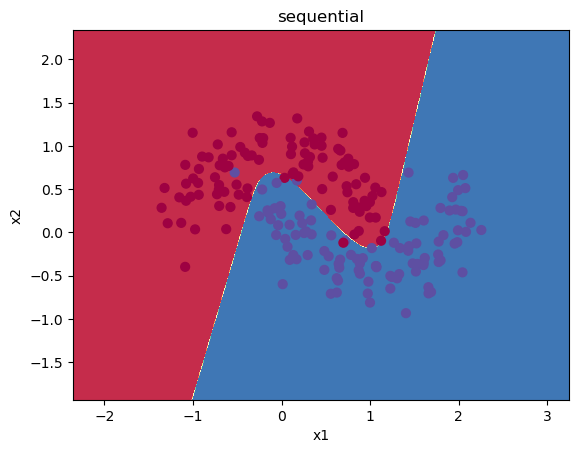

In [12]:
plot_decision_boundary(lambda x: plot_seq(x), x.numpy(), y.numpy())
plt.title('sequential')
plt.show()

### 2.2 保存模型参数

保存模型在 PyTorch 中有两种方式，一种是将模型结构和参数都保存在一起，一种是只将参数保存下来。

In [22]:
# 将参数和模型保存在一起
torch.save(seq_net, 'save_seq_net.pth')

上面就是保存模型的方式，`torch.save`里面有两个参数，第一个是要保存的模型，第二个参数是保存的路径，读取模型的方式也非常简单

In [24]:
# 读取保存的模型
seq_net1 = torch.load('save_seq_net.pth', weights_only=False)

In [25]:
seq_net1

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [26]:
print(seq_net1[0].weight)

Parameter containing:
tensor([[ 3.0749,  0.3511],
        [ 2.2696, -1.5330],
        [ 3.0667, -0.7830],
        [-3.3794, -2.7778]], requires_grad=True)


我们可以看到我们重新读入了模型，并且将其命名为 seq_net1，并且打印了第一层的参数

下面我们看看第二种保存模型的方式，只保存参数而不保存模型结构

In [27]:
# 保存模型参数
torch.save(seq_net.state_dict(), 'save_seq_net_params.pth')

通过上面的方式，我们保存了模型的参数，如果要重新读入模型的参数，首先我们需要重新定义一次模型，接着重新读入参数

In [29]:
seq_net2 = nn.Sequential(
    nn.Linear(2, 4),
    nn.Tanh(),
    nn.Linear(4, 1)
)

seq_net2.load_state_dict(torch.load('save_seq_net_params.pth', weights_only=True))

<All keys matched successfully>

In [30]:
seq_net2

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Tanh()
  (2): Linear(in_features=4, out_features=1, bias=True)
)

In [31]:
print(seq_net2[0].weight)

Parameter containing:
tensor([[ 3.0749,  0.3511],
        [ 2.2696, -1.5330],
        [ 3.0667, -0.7830],
        [-3.3794, -2.7778]], requires_grad=True)


通过这种方式我们也重新读入了相同的模型，打印第一层的参数对比，发现和前面的办法是一样

有这两种保存和读取模型的方法，我们推荐使用**第二种**，因为第二种可移植性更强

### 2.3 Module

下面再用 Module 定义这个模型，下面是使用 Module 的模板

```
class 网络名字(nn.Module):
    def __init__(self, 一些定义的参数):
        super(网络名字, self).__init__()
        self.layer1 = nn.Linear(num_input, num_hidden)
        self.layer2 = nn.Sequential(...)
        ...
        
        定义需要用的网络层
        
    def forward(self, x): # 定义前向传播
        x1 = self.layer1(x)
        x2 = self.layer2(x)
        x = x1 + x2
        ...
        return x
```

注意的是，Module 里面也可以使用 Sequential，同时 Module 非常灵活，具体体现在 forward 中，如何复杂的操作都能直观的在 forward 里面执行

下面我们照着模板实现一下上面的神经网络

In [33]:
class SimpNet(nn.Module):
    def __init__(self, num_input, num_hidden, num_output):
        super(SimpNet, self).__init__()
        
        self.layer1 = nn.Linear(num_input, num_hidden)
        self.layer2 = nn.Tanh()
        self.layer3 = nn.Linear(num_hidden, num_output)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [34]:
mo_net = SimpNet(2, 4, 1)

In [35]:
# 访问模型中的某层可以直接通过名字

# 第一层
l1 = mo_net.layer1
print(l1)

Linear(in_features=2, out_features=4, bias=True)


In [36]:
# 打印出第一层的权重
print(l1.weight)

Parameter containing:
tensor([[ 0.4554,  0.6080],
        [ 0.0761,  0.1059],
        [-0.3099,  0.0688],
        [ 0.1636,  0.6779]], requires_grad=True)


In [37]:
# 定义优化器
optim = torch.optim.SGD(mo_net.parameters(), 1.)

In [38]:
# 我们训练 10000 次
for e in range(10000):
    out = mo_net(x)
    loss = criterion(out, y)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if (e + 1) % 1000 == 0:
        print('epoch: {}, loss: {}'.format(e+1, loss.item()))

epoch: 1000, loss: 0.12355199456214905
epoch: 2000, loss: 0.06917361170053482
epoch: 3000, loss: 0.0663343146443367
epoch: 4000, loss: 0.06464790552854538
epoch: 5000, loss: 0.06295064091682434
epoch: 6000, loss: 0.061607275158166885
epoch: 7000, loss: 0.060556601732969284
epoch: 8000, loss: 0.0596991665661335
epoch: 9000, loss: 0.058966562151908875
epoch: 10000, loss: 0.05831938236951828


In [39]:
# 保存模型
torch.save(mo_net.state_dict(), 'module_net.pth')

可以看到我们得到了相同的结果，而且使用 Sequential 和 Module 来定义模型更加方便


## 练习题

* 改变网络的隐藏层神经元数目，或者试试定义一个 5 层甚至更深的模型，增加训练次数，改变学习率，看看结果会怎么样